🔄 Caricamento e preparazione dati MNIST...
✅ Dati preparati:
- Training set: 60000 campioni
- Test set:     10000 campioni
Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6240 - loss: 1.1018 - val_accuracy: 0.9352 - val_loss: 0.2462
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8616 - loss: 0.4450 - val_accuracy: 0.9542 - val_loss: 0.1524
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8988 - loss: 0.3339 - val_accuracy: 0.9623 - val_loss: 0.1193
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9157 - loss: 0.2821 - val_accuracy: 0.9702 - val_loss: 0.0991
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9268 - loss: 0.2448 - val_accuracy: 0.9730 - val_loss: 0.0854
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9330 - loss: 0.2224 - val_accuracy: 0.9763 - val_loss: 0.0769
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9400 - loss: 0.2060 - val_acc

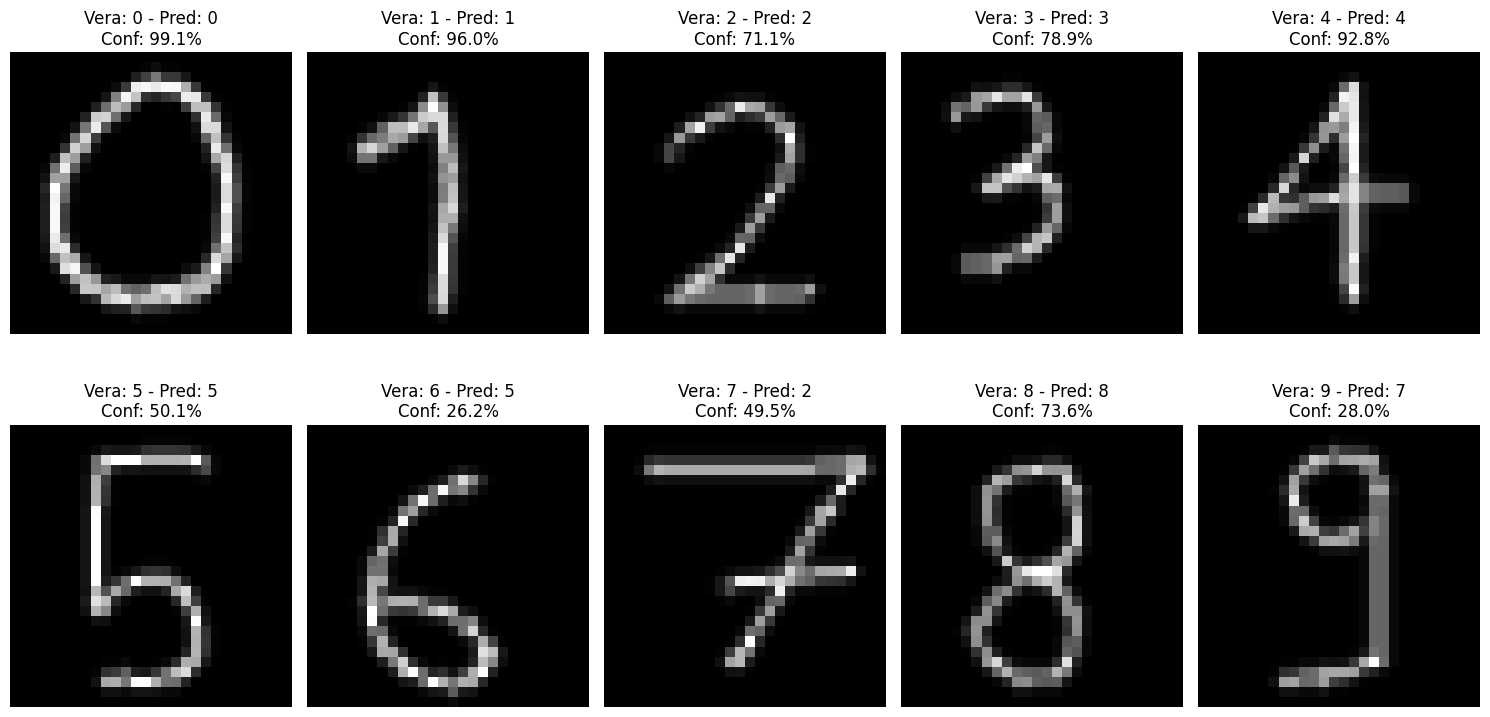


🏁 Fine esercizio.


In [7]:
# Importa il modulo per interagire con il sistema operativo (verifica file presenti)
import os

# ──────────────── IMPOSTAZIONI PER STABILITÀ E RIPRODUCIBILITÀ ────────────────

# Disabilita la GPU per forzare l'esecuzione su CPU (evita instabilità su alcune macchine)
os.environ['CUDA_VISIBLE_DEVICES'] = ''              

# Limita i thread usati da librerie matematiche per evitare sovraccarichi
os.environ['OMP_NUM_THREADS']      = '1'           
os.environ['MKL_NUM_THREADS']      = '1'           
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'       

# Disattiva i warning di TensorFlow per log più pulito
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'          

# Importa librerie standard e Keras
import gc                          # Garbage collector per pulizia memoria
import time                        # Pausa per rilascio risorse
import numpy as np                # Calcoli numerici
import matplotlib.pyplot as plt   # Grafici
from PIL import Image             # Caricamento immagini PNG
import tensorflow as tf
from tensorflow.keras import backend as K, layers, models, datasets, utils
from tensorflow.keras.optimizers import SGD

# Limita l'uso di thread anche da parte di TensorFlow
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Imposta seed per la riproducibilità (risultati deterministici)
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# ──────────────── FUNZIONE DI PULIZIA MEMORIA ────────────────

def clean_memory():
    """Libera risorse e memoria per evitare crash o sovraccarichi del kernel."""
    K.clear_session()
    gc.collect()
    plt.close('all')
    time.sleep(0.05)

# ──────────────── CARICAMENTO E PREPARAZIONE DEI DATI ────────────────

clean_memory()  # Pulisce la memoria prima di iniziare
print("🔄 Caricamento e preparazione dati MNIST...")

# Carica il dataset MNIST predefinito (28x28 pixel, cifre 0-9)
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Normalizza i valori dei pixel tra 0 e 1
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

# Converte le etichette da interi (es. 5) a one-hot vector (es. [0 0 0 0 0 1 0 0 0 0])
y_train = utils.to_categorical(y_train, 10)
y_test  = utils.to_categorical(y_test, 10)

# Aggiunge un canale (1) per adattare i dati alla CNN (shape: 28x28x1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

# Stampa la forma dei dati caricati
print("✅ Dati preparati:")
print(f"- Training set: {X_train.shape[0]} campioni")
print(f"- Test set:     {X_test.shape[0]} campioni")

# ──────────────── DEFINIZIONE DEL MODELLO CNN (ES. 12.2) ────────────────

def create_CNN():
    """Definisce una CNN come richiesto dall’esercizio 12.2."""
    model = models.Sequential()

    # Primo strato convoluzionale: 10 filtri 5x5, ReLU
    model.add(layers.Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv1'))
    # Pooling + Dropout per ridurre overfitting
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='dropout1'))

    # Secondo strato convoluzionale: 20 filtri 5x5, ReLU
    model.add(layers.Conv2D(20, kernel_size=(5, 5), activation='relu', name='conv2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))

    # Appiattisce l’output per passarlo al layer denso
    model.add(layers.Flatten(name='flatten'))

    # Strato denso con 64 neuroni, ReLU
    model.add(layers.Dense(64, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.5, name='dropout3'))

    # Strato di output: 10 neuroni softmax (uno per ogni cifra)
    model.add(layers.Dense(10, activation='softmax', name='output'))

    # Compila il modello con ottimizzatore SGD e loss CCE
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

    return model

# ──────────────── CREAZIONE E ADDESTRAMENTO MODELLO ────────────────

# Specifiche della consegna
batch_size = 32
epochs     = 30

# Crea la CNN
model_12_2 = create_CNN()

# Addestra il modello con i dati MNIST
history_12_2 = model_12_2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_data=(X_test, y_test),
    verbose=1
)

# Valuta le performance sul test set
test_loss_12_2, test_acc_12_2 = model_12_2.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc_12_2:.4f}")
print(f"Test Loss:     {test_loss_12_2:.4f}")


# ──────────────── ESERCIZIO 12.3: TEST SU CIFRE SCRITTE A MANO ────────────────

# Percorsi alle immagini create manualmente (0.png, 1.png, ..., 9.png)
digit_paths = [f"{i}.png" for i in range(10)]

# Verifica esistenza file nella directory
for path in digit_paths:
    if not os.path.exists(path):
        print(f"⚠️ Mancante: {path}")

# Se tutte le immagini sono presenti, procedi
plt.figure(figsize=(15, 8))
for i, path in enumerate(digit_paths):
    # Carica immagine, converte in scala di grigi (L) e normalizza
    img = Image.open(path).convert('L')
    img_data = np.array(img) / 255.0

    # Inversione colori se sfondo è chiaro e cifre scure
    if np.mean(img_data) > 0.5:
        img_data = 1 - img_data

    # Ridimensiona se immagine non è 28x28
    if img_data.shape != (28, 28):
        img = img.resize((28, 28))
        img_data = np.array(img) / 255.0

    # Reshape per CNN
    input_data = img_data.reshape(1, 28, 28, 1)

    # Predizione
    prediction = model_12_2.predict(input_data)
    digit = np.argmax(prediction)
    confidence = np.max(prediction)

    # Visualizza immagine e predizione
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_data, cmap='gray')
    plt.title(f"Vera: {i} - Pred: {digit}\nConf: {confidence:.1%}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# ──────────────── PULIZIA ────────────────

# Rimuove il modello dalla memoria e libera risorse
del model_12_2
clean_memory()
print("\n🏁 Fine esercizio.")


# Esercizio 12.3


L'accuracy è elevata con una corretta predizione della maggior parte delle cifre. L'alta e conforme confidenza di ogni predizione è segno che la rete è capace a riconoscere le cifre disegnate a mano. 

Una possibile interpretazione della mancata predizione dei numeri 6, 7, e 9 è da ricondursi alla topologia dei simboli impiegati per i numeri. 

Il 6 presenta una "pancia" proprio come è presente nel tratto del 5.

Il disegno del 7 presenta nella parte superiore una forma a zeta come il 2. Se avessi disegnato il 7 senza il tratto centrale, come nel dataset del MINST, mi aspetterei una predizione corretta. 

L'immagine del 9 presenta un'estensione simile al 7.